In [79]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

In [80]:
def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=1):
    data = []

    x = scale*(np.round(np.random.random_sample((n,)).astype(np.float32),decimals=2)-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [81]:
def plot(X):
    plt.scatter(X[:,0], X[:,1])

## Tensorflow variables

In [82]:
class GeneratorModel(tf.keras.Model):
  def __init__(self, dims=[16,16]):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=dims[0],
                                        activation=tf.nn.leaky_relu)
    self.dense2 = tf.keras.layers.Dense(units=dims[1],
                                        activation=tf.nn.leaky_relu)
    self.dense3 = tf.keras.layers.Dense(units=2)

  def call(self, x, training=True):
    x = self.dense1(x)
    x = self.dense2(x)
    return self.dense3(x)


In [83]:
class DiscrimiatorModel(tf.keras.Model):
  def __init__(self, dims=[16,16]):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=dims[0],
                                        activation=tf.nn.leaky_relu)
    self.dense2 = tf.keras.layers.Dense(units=dims[1],
                                        activation=tf.nn.leaky_relu)
    self.dense3 = tf.keras.layers.Dense(units=2)
    self.dense4 = tf.keras.layers.Dense(units=1)

  def call(self, x, training=True):
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    out = self.dense4(x)
    return out





In [84]:
gen = GeneratorModel(dims=[32,32])
disc = DiscrimiatorModel(dims=[32,32])

In [85]:
batch_size = 100

In [86]:
def print_values(model):
    X = sample_data(n=batch_size)
    plt.figure()
    plot(X)

    Z = tf.random.uniform([batch_size, 2])

    x_gen = model(Z, training=False)

    plot(x_gen)


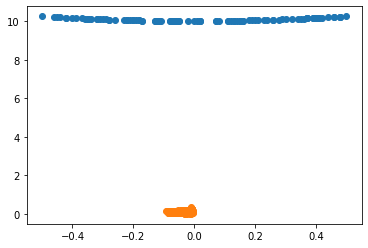

In [87]:
print_values(gen)

In [88]:
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def cross_entropy(labels, output):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=labels)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_mean(total_loss)
    #return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))
    #return cross_entropy(tf.ones_like(fake_output), fake_output)

2022-06-02 21:15:02.514166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Gen. Mean squared error: 0.685
Disc. Mean squared error: 0.957
Distance: 5.105
Gen. Mean squared error: 0.781
Disc. Mean squared error: 1.274
Distance: 3.055
Gen. Mean squared error: 0.884
Disc. Mean squared error: 1.480
Distance: 3.507
Gen. Mean squared error: 0.579
Disc. Mean squared error: 1.392
Distance: 1.648
Gen. Mean squared error: 0.768
Disc. Mean squared error: 1.341
Distance: 0.776
Gen. Mean squared error: 0.930
Disc. Mean squared error: 1.358
Distance: 1.722
Gen. Mean squared error: 0.769
Disc. Mean squared error: 1.403
Distance: 1.260
Gen. Mean squared error: 0.620
Disc. Mean squared error: 0.981
Distance: 1.716
Gen. Mean squared error: 0.602
Disc. Mean squared error: 0.864
Distance: 3.757
Gen. Mean squared error: 16.116
Disc. Mean squared error: 1.211
Distance: 4.297
Gen. Mean squared error: 0.559
Disc. Mean squared error: 1.617
Distance: 1.713
Gen. Mean squared error: 0.739
Disc. Mean squared error: 1.331
Distance: 0.495
Gen. Mean squared error: 0.021
Disc. Mean squared e

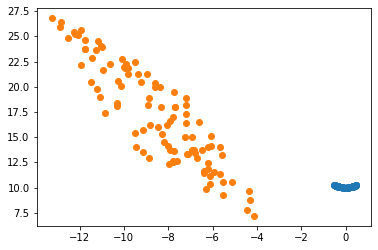

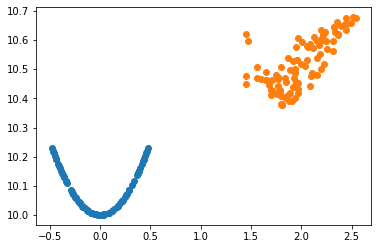

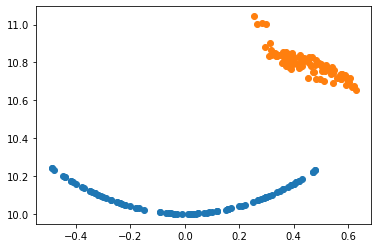

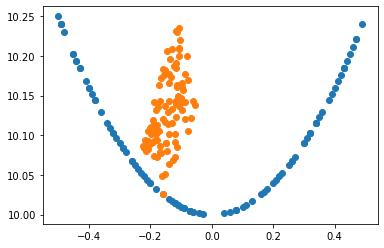

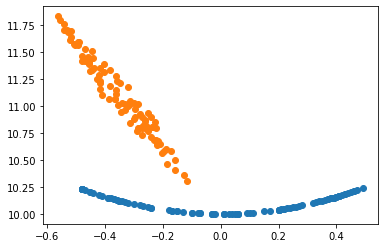

In [89]:
gen_variables = gen.variables
disc_variables = disc.variables

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

noise_dim = 2

@tf.function
def train_step(X):
    noise = tf.random.uniform([batch_size, noise_dim])

    dist = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gen(noise, training=True)

      dist = tf.abs(tf.cast(generated_images, tf.float64) - X)

      real_output = disc(X, training=True)
      fake_output = disc(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

    return gen_loss, disc_loss, dist

list_gen_loss = []
list_disc_loss = []
dists = []
for step in range(20001):
  X = sample_data(n=batch_size)
  gen_loss, disc_loss, dist = train_step(X)
  list_gen_loss.append(gen_loss.numpy())
  list_disc_loss.append(disc_loss.numpy())
  dists.append(dist.numpy().mean())
                           
  

  if step % 100 == 0:
    print(f'Gen. Mean squared error: {gen_loss.numpy():0.3f}')
    print(f'Disc. Mean squared error: {disc_loss.numpy():0.3f}')
    print(f'Distance: {dist.numpy().mean():0.3f}')

  if dist.numpy().mean() < 0.1:
    print_values(gen)
    print(f'Early stop: {gen_loss.numpy():0.3f}')
    break

  if step % 5000 == 0:
    print_values(gen)


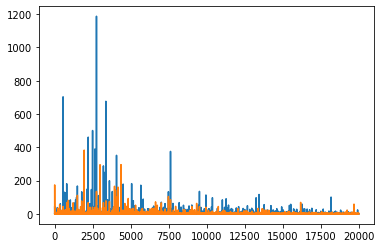

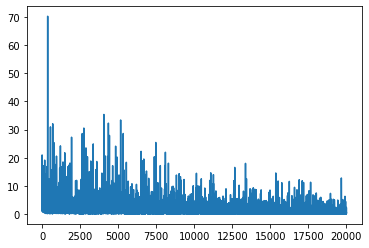

In [90]:
plt.plot(list_gen_loss, label="Gen")
plt.plot(list_disc_loss, label="Disc")
plt.figure()
plt.plot(dists)

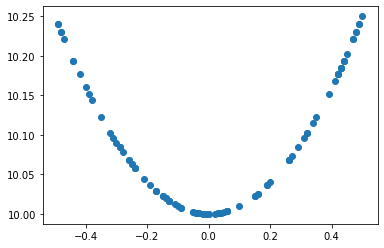

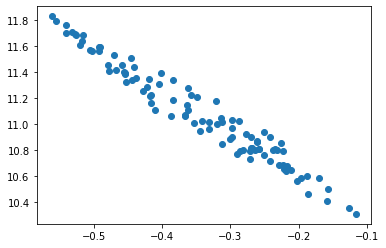

In [91]:
X = sample_data(n=batch_size)
plot(X)

Z = tf.random.uniform([batch_size, 2])
plt.figure()

x_gen = gen(Z, training=False)

plot(x_gen)
